In [ ]:
!pip install pydub
!pip install SpeechRecognition
!apt-get install ffmpeg

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import scipy.io.wavfile as wav
import speech_recognition as sr
from IPython.display import Audio, display
import os
import librosa.feature
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,AveragePooling1D ,Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import  regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 43.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.makedirs('/content/Audio', exist_ok=True)
os.makedirs('/content/AugmentedAudio', exist_ok=True)
os.makedirs('/content/ImprovedAudio', exist_ok=True)
os.makedirs('/content/NoiseAudio', exist_ok=True)
os.makedirs('/content/ShiftAudio', exist_ok=True)
os.makedirs('/content/PitchAudio', exist_ok=True)
os.makedirs('/content/TimeAudio', exist_ok=True)
os.makedirs('/content/TestAudio', exist_ok=True)

In [ ]:
!unzip /content/gdrive/MyDrive/Crema.zip -d /content/Audio

Streaming output truncated to the last 5000 lines.
  inflating: /content/Audio/1031_DFA_DIS_XX.wav  
  inflating: /content/Audio/1031_DFA_FEA_XX.wav  
  inflating: /content/Audio/1031_DFA_HAP_XX.wav  
  inflating: /content/Audio/1031_DFA_NEU_XX.wav  
  inflating: /content/Audio/1031_DFA_SAD_XX.wav  
  inflating: /content/Audio/1031_IEO_ANG_HI.wav  
  inflating: /content/Audio/1031_IEO_ANG_LO.wav  
  inflating: /content/Audio/1031_IEO_ANG_MD.wav  
  inflating: /content/Audio/1031_IEO_DIS_HI.wav  
  inflating: /content/Audio/1031_IEO_DIS_LO.wav  
  inflating: /content/Audio/1031_IEO_DIS_MD.wav  
  inflating: /content/Audio/1031_IEO_FEA_HI.wav  
  inflating: /content/Audio/1031_IEO_FEA_LO.wav  
  inflating: /content/Audio/1031_IEO_FEA_MD.wav  
  inflating: /content/Audio/1031_IEO_HAP_HI.wav  
  inflating: /content/Audio/1031_IEO_HAP_LO.wav  
  inflating: /content/Audio/1031_IEO_HAP_MD.wav  
  inflating: /content/Audio/1031_IEO_NEU_XX.wav  
  inflating: /content/Audio/1031_IEO_SAD_HI.wav  

In [ ]:
def SoundWav(aud):
  x=aud.split("_")
  mode=x[2]

  if mode=='ANG':
    mode='ANGRY'
  elif mode=='DIS':
    mode='DISGUST'
  elif mode=='FEA':
    mode='FEAR'
  elif mode=='HAP':
    mode='HAPPY'
  sample_rate, data = wav.read(aud)
  # Create the time axis
  duration = len(data) / sample_rate
  time = np.linspace(0., duration, len(data))

  # Create the waveform trace
  waveform_trace = go.Scatter(x=time, y=data, mode='lines')

  # Create the layout
  layout = go.Layout(
      title='Audio Waveform for ' + str(mode) + ' audio',
      xaxis=dict(title='Time (s)'),
      yaxis=dict(title='Amplitude')
  )
  fig = go.Figure(data=[waveform_trace], layout=layout)
  fig.show()

In [ ]:
def SpectoGraph(aud):
  audio, sample_rate = librosa.load(aud)

  # Compute the spectrogram
  spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

  # Convert to decibels
  spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

  # Plot the spectrogram
  librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')
  plt.show()


In [ ]:
def SoundRecognizer(aud):
  # Create a recognizer object
  r = sr.Recognizer()

  # Load the audio file
  audio_file = sr.AudioFile(aud)

  # Open the audio file and read the audio data
  with audio_file as source:
      audio = r.record(source)

  # Perform speech recognition
  text = r.recognize_google(audio)

  # Print the recognized text
  print()
  print("Audio to text: "+str(text))
  print()

In [ ]:
def AudioReader(aud):



  SoundWav(aud)
  SpectoGraph(aud)
  SoundRecognizer(aud)
  display(Audio(aud, autoplay=True))




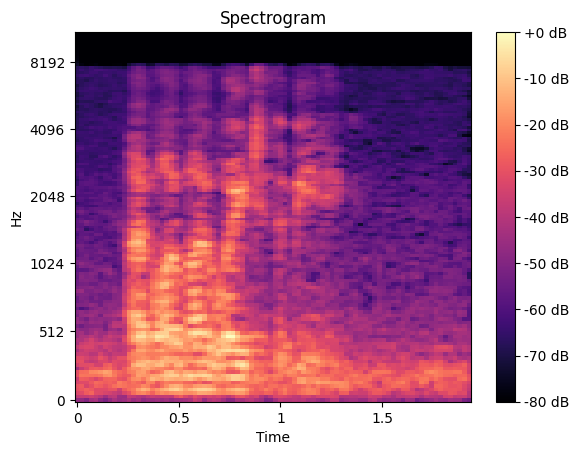


Audio to text: I'm on my way to the meeting



In [ ]:
AudioReader('/content/Audio/1001_IOM_SAD_XX.wav')

Extracting Features

In [ ]:
def add_noise(audio):
  noise = np.random.randn(len(audio))
  scale_factor=0.1
  augmented_audio = audio + scale_factor * noise
  return augmented_audio
def shifting(audio,rate=1000):
  augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
  augmented_data=np.roll(audio,augmented_data)
  return augmented_data
def pitching(audio,sr):
  augmented_data = librosa.effects.pitch_shift(audio,sr=sr,n_steps=2)
  return augmented_data

In [ ]:
def ExtractFeatures(audio,frame_length,hop_length):
    zcr = librosa.feature.zero_crossing_rate(audio,frame_length=frame_length, hop_length=hop_length)[0]
    mean_value = np.mean(zcr)
    std_value = np.std(zcr)
    zcr = (zcr - mean_value) / std_value

    energy = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    mean_value = np.mean(energy)
    std_value = np.std(energy)
    energy = (energy - mean_value) / std_value

    autocorr = librosa.autocorrelate(audio, max_size=frame_length)
    mean_value = np.mean(autocorr)
    std_value = np.std(autocorr)
    autocorr = (autocorr - mean_value) / std_value

    NewAudio = np.hstack((zcr,energy))
    # NewAudio = np.hstack((NewAudio,autocorr))
    return NewAudio

In [ ]:
!unzip /content/gdrive/MyDrive/Noise_aud3.zip -d /content/NoiseAudio

In [ ]:
!unzip /content/gdrive/MyDrive/Pitch_aud3.zip -d /content/PitchAudio

In [ ]:
!unzip /content/gdrive/MyDrive/Shift_aud3.zip -d /content/ShiftAudio

In [ ]:
directory_path = '/content/Audio/'
updated_path = '/content/ImprovedAudio/'
max_audio=0
# Loop over all files in the directory


for filename in os.listdir(directory_path):
    if filename.endswith('.wav'):
        # Load the audio file
        frame_length = 2048
        hop_length = 512
        audio, sr = librosa.load(os.path.join(directory_path, filename))
        # noised_audio=add_noise(audio)
        # shifted_audio=shifting(audio)
        pitched_audio=pitching(audio,sr)
        normal_aud=ExtractFeatures(audio,frame_length,hop_length)
        # noised_aud=ExtractFeatures(noised_audio,frame_length,hop_length)
        # shifted_aud=ExtractFeatures(shifted_audio,frame_length,hop_length)
        pitched_aud=ExtractFeatures(pitched_audio,frame_length,hop_length)
        max_size=max(normal_aud.shape[0],pitched_aud.shape[0])
        if(max_size>max_audio):
          max_audio=max_size
        # Save the processed audio file to a new location
        x=filename.split("_")

        fileupdated=updated_path+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_normal.wav'
        if not os.path.exists(fileupdated):
          sf.write(fileupdated,normal_aud,sr)
        # fileupdated=updated_path+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_noised.wav'
        # if not os.path.exists(fileupdated):
        #   sf.write(fileupdated,noised_aud,sr)
        # fileupdated=updated_path+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_shifted.wav'
        # if not os.path.exists(fileupdated):
        #   sf.write(fileupdated,shifted_aud,sr)
        fileupdated=updated_path+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_pitched.wav'
        if not os.path.exists(fileupdated):
          sf.write(fileupdated,pitched_aud,sr)

<ipython-input-6-1a05ddbf1362>:5: RuntimeWarning: invalid value encountered in true_divide
  zcr = (zcr - mean_value) / std_value
<ipython-input-6-1a05ddbf1362>:10: RuntimeWarning: invalid value encountered in true_divide
  energy = (energy - mean_value) / std_value
<ipython-input-6-1a05ddbf1362>:15: RuntimeWarning: invalid value encountered in true_divide
  autocorr = (autocorr - mean_value) / std_value


In [ ]:
import shutil

file_path = '/content/ImprovedAudio'
zip_path = '/content/Improved7_aud'
shutil.make_archive(zip_path, 'zip', '.', file_path)

'/content/Improved7_aud.zip'

In [ ]:
destination_drive_path = '/content/gdrive/MyDrive/'
# Move the zip file to Google Drive
shutil.move(zip_path+'.zip', destination_drive_path)

'/content/gdrive/MyDrive/Improved7_aud.zip'

In [ ]:
directory_path = '/content/Audio/'
max_aud=0
for filename in os.listdir(directory_path):
    if filename.endswith('.wav'):
        # Load the audio file
        audio, sr = librosa.load(os.path.join(directory_path, filename))
        noised_audio=add_noise(audio)
        pitched_audio=pitching(audio,sr)
        m=max(audio.shape[0],noised_audio.shape[0],pitched_audio.shape[0])
        if (m>max_aud):
          max_aud=m

In [ ]:
max_aud=110361

In [ ]:
# def AudioTrain():
#   audio_paths = [
#       '/content/Audio',
#       '/content/NoiseAudio',
#       '/content/ShiftAudio',
#       '/content/PitchAudio',
#   ]
#   updated_path = '/content/3DPhoto/'
#   y_true = []
#   max_audio=648
#   # Loop over all audio paths
#   spectrogram_list = []
#   audio_list= []
#   frame_length = 2048
#   hop_length = 512
#   for audio_path in audio_paths:
#     for filename in os.listdir(audio_path):
#         if filename.endswith('.wav'):
#             # Load the audio file
#             audio, sr = librosa.load(os.path.join(audio_path, filename))
#             AudioExtract=ExtractFeatures(audio,frame_length,hop_length)
#             required_size=max_audio-AudioExtract.shape[0]
#             audioExtract = np.pad(AudioExtract, (0, required_size), mode='constant')
#             audio_list.append(audioExtract)
#             x=filename.split("_")
#             mode=x[2]
#             if mode=='ANG':
#               mode='ANGRY'
#             elif mode=='DIS':
#               mode='DISGUST'
#             elif mode=='FEA':
#               mode='FEAR'
#             elif mode=='HAP':
#               mode='HAPPY'
#             elif mode=='NEU':
#               mode='NEUTRAL'
#             y_true.append(mode)
#   Audios = np.vstack(audio_list).astype(np.float32)
#   X_train_val, X_test, y_train_val, y_test = train_test_split(Audios, y_true, test_size = 0.3,stratify =y_true ,random_state=42)
#   X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,stratify =y_train_val,test_size=0.05, random_state=42)
#   return X_train, X_test,X_val, y_train, y_test,y_val


In [ ]:
# X_train, X_test,X_val, y_train, y_test,y_val = AudioTrain()

In [ ]:
# import shutil

# file_path = '/content/ImprovedAudio'
# zip_path = '/content/Improved_aud3'
# shutil.make_archive(zip_path, 'zip', '.', file_path)

'/content/Improved_aud3.zip'

In [ ]:
# destination_drive_path = '/content/gdrive/MyDrive/'
# # Move the zip file to Google Drive
# shutil.move(zip_path+'.zip', destination_drive_path)

In [ ]:
!unzip /content/gdrive/MyDrive/Improved7_aud.zip -d /content/AugmentedAudio

Archive:  /content/gdrive/MyDrive/Improved7_aud.zip
replace /content/AugmentedAudio/ImprovedAudio/1083_ITH_HAP_XX.wav_pitched.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
max_audio=0
directory_path = '/content/AugmentedAudio/ImprovedAudio'
audio_list = []
y_true=[]
for filename in os.listdir(directory_path):
      if filename.endswith('.wav'):
        audio, sample_rate = librosa.load(os.path.join(directory_path, filename))
        if (audio.shape[0]>max_audio):
          max_audio=audio.shape[0]
max_audio

432

In [ ]:
max_audio=648

In [ ]:
directory_path = '/content/AugmentedAudio'

# Initialize file count
file_count = 0

# Iterate through the files in the directory
for _, _, files in os.walk(directory_path):
    file_count += len(files)

print("Number of files in the directory:", file_count)

Number of files in the directory: 14884


In [ ]:
def AudioArray():
  directory_path = '/content/AugmentedAudio/ImprovedAudio'
  audio_list = []
  y_true=[]
  # Loop over all files in the directory
  for filename in os.listdir(directory_path):
      if filename.endswith('.wav'):
          # Load the audio file
          audio, sample_rate = librosa.load(os.path.join(directory_path, filename))
          required_size=max_audio-audio.shape[0]
          audio = np.pad(audio, (0, required_size), mode='constant')
          audio_list.append(audio)
          x=filename.split("_")
          mode=x[2]

          if mode=='ANG':
            mode='ANGRY'
          elif mode=='DIS':
            mode='DISGUST'
          elif mode=='FEA':
            mode='FEAR'
          elif mode=='HAP':
            mode='HAPPY'
          elif mode=='NEU':
            mode='NEUTRAL'
          y_true.append(mode)

  Audios = np.vstack(audio_list).astype(np.float32)
  X_train_val, X_test, y_train_val, y_test = train_test_split(Audios, y_true, test_size = 0.3,stratify =y_true ,random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,stratify =y_train_val,test_size=0.05, random_state=42)

  return X_train, X_test,X_val, y_train, y_test,y_val


In [ ]:
X_train, X_test,X_val, y_train, y_test,y_val = AudioArray()

In [ ]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [ ]:
# scaler = StandardScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)
# X_val=scaler.transform(X_val)

In [ ]:
# Convert string labels to categorical labels
label_map = {label: index for index, label in enumerate(np.unique(y_train, axis=0))}
y_train_encoded = to_categorical([label_map[label] for label in y_train])
y_test_encoded = to_categorical([label_map[label] for label in y_test])
y_val_encoded = to_categorical([label_map[label] for label in y_val])

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Set the input shape and number of classes
input_shape = (X_train.shape[1], 1)  # Define your input shape
num_classes = 6  # Define the number of classes

# Create the CNN model
model = Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(MaxPooling1D(pool_size=3,padding='same'))

model.add(Conv1D(128, kernel_size=3, activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=3, activation='relu',padding='same'))
model.add(MaxPooling1D(pool_size=2))


# model.add(Dropout(0.5))


# model.add(Conv1D(256, kernel_size=5, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))



# model.add(Conv1D(1024, kernel_size=9, activation='relu', input_shape=input_shape, dilation_rate=2))
# model.add(yooling1D(pool_size=2))


# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Print the model summary
model.summary()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train_encoded, batch_size=64, epochs=60, validation_data=(X_val, y_val_encoded))
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 432, 64)           256       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 144, 64)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 144, 128)          24704     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 72, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 72, 256)           98560     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 36, 256)         

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
inv_label_map = {v: k for k, v in label_map.items()}
y_pred_decoded = [inv_label_map[label] for label in y_pred]

140/140 [==============================] - 0s 2ms/step


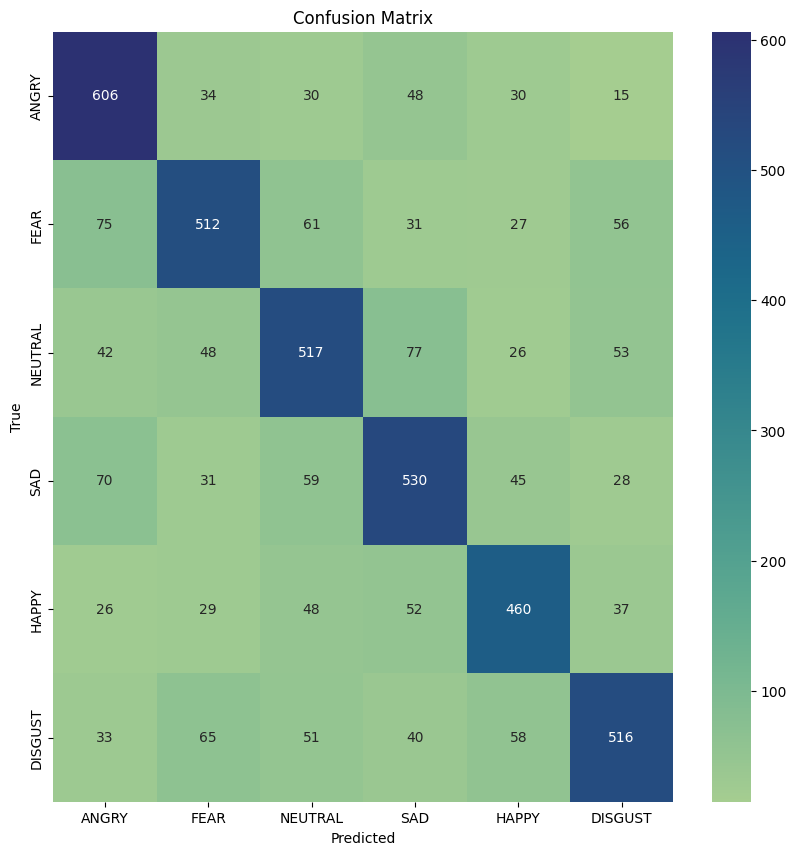

In [ ]:
cm = confusion_matrix(y_test, y_pred_decoded)
plt.figure(figsize=(10,10))
labels=['ANGRY','FEAR','NEUTRAL','SAD','HAPPY','DISGUST']
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

preci=TP/(TP+FP)
recall=TP/(TP+FN)

F_score= 2*preci*recall/(preci+recall)


In [ ]:
print('F-score: '+str(F_score.sum()/F_score.size *100)+'%')

F-score: 70.29655237867087%


# 2D Conv

In [ ]:
directory_path = '/content/Audio/'
max_aud=0
for filename in os.listdir(directory_path):
    if filename.endswith('.wav'):
        # Load the audio file
        audio, sr = librosa.load(os.path.join(directory_path, filename))
        pitched_audio=pitching(audio,sr)
        m=max(audio.shape[0],pitched_audio.shape[0])
        if (m>max_aud):
          max_aud=m

In [ ]:
max_aud

110361

In [ ]:
# directory_path = '/content/Audio/'
# updated_path = '/content/NoiseAudio/'
# updated_path1 = '/content/PitchAudio/'
# updated_path2 = '/content/ShiftAudio/'
# updated_path3 = '/content/TimeAudio/'
# for filename in os.listdir(directory_path):
#     if filename.endswith('.wav'):
#         audio_data=[]  # List to store the audio data
#         audio, sr = librosa.load(os.path.join(directory_path, filename))
#         audio_data.append(audio)
#         noised_audio=add_noise(audio)
#         audio_data.append(noised_audio)
#         shifted_audio=shifting(audio)
#         audio_data.append(shifted_audio)
#         pitched_audio=pitching(audio,sr)
#         audio_data.append(pitched_audio)
#         audio_data=np.array(audio_data)
#         # required_size=max_aud-len(audio_data[0])
#         # audio_data = np.pad(audio_data, ((0, 0), (0,required_size)), mode='constant')
#         x=filename.split("_")
#         fileupdated = updated_path + x[0] + '_' + x[1] + '_' + x[2] + '_Noise.wav'
#         if not os.path.exists(fileupdated):
#             sf.write(fileupdated,noised_audio,sr)
#         fileupdated = updated_path1 + x[0] + '_' + x[1] + '_' + x[2] + '_Pitch.wav'
#         if not os.path.exists(fileupdated):
#             sf.write(fileupdated,shifted_audio,sr)
#         fileupdated = updated_path2 + x[0] + '_' + x[1] + '_' + x[2]  + '_Shift.wav'
#         if not os.path.exists(fileupdated):
#             sf.write(fileupdated,pitched_audio,sr)


In [ ]:
# import shutil

# file_path = '/content/NoiseAudio'
# zip_path = '/content/Noise_aud4'
# shutil.make_archive(zip_path, 'zip', '.', file_path)

# file_path1 = '/content/PitchAudio'
# zip_path1 = '/content/Pitch_aud4'
# shutil.make_archive(zip_path1, 'zip', '.', file_path1)

# file_path2 = '/content/ShiftAudio'
# zip_path2 = '/content/Shift_aud4'
# shutil.make_archive(zip_path2, 'zip', '.', file_path2)



'/content/Stretch_aud4.zip'

In [ ]:
# destination_drive_path = '/content/gdrive/MyDrive/'
# # Move the zip file to Google Drive
# shutil.move(zip_path+'.zip', destination_drive_path)
# shutil.move(zip_path1+'.zip', destination_drive_path)
# shutil.move(zip_path2+'.zip', destination_drive_path)


'/content/gdrive/MyDrive/Stretch_aud4.zip'

In [ ]:
from PIL import Image

audio_paths = [
    '/content/Audio',
    '/content/PitchAudio/PitchAudio',
]
updated_path = '/content/3DPhoto/'
y_label = []

# Loop over all audio paths
spectrogram_list = []
for audio_path in audio_paths:
  for filename in os.listdir(audio_path):
      if filename.endswith('.wav'):
          # Load the audio file
          audio_data=[]  # List to store the audio data
          audio, sr = librosa.load(os.path.join(audio_path, filename))
          audio_data.append(audio)
          audio_data=np.array(audio_data)

          # Compute the spectrogram
          spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
          # Convert to decibels
          spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

          spectrogram_db = np.squeeze(spectrogram_db)
          default_width = 224
          default_height = 128

          # Resize the image
          resized_image = Image.fromarray(spectrogram_db)
          resized_image = resized_image.resize((default_width, default_height))
          resized_spectrogram_db = np.array(resized_image)


          # Append the spectrogram and label to the lists
          spectrogram_list.append(resized_spectrogram_db)

                  # Save the processed audio file to a new location
          x=filename.split("_")
          mode=x[2]
          if mode=='ANG':
            mode='ANGRY'
          elif mode=='DIS':
            mode='DISGUST'
          elif mode=='FEA':
            mode='FEAR'
          elif mode=='HAP':
            mode='HAPPY'
          elif mode=='NEU':
            mode='NEUTRAL'
          y_label.append(mode)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(spectrogram_list, y_label, test_size = 0.3,stratify =y_label ,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,stratify =y_train_val,test_size=0.05, random_state=42)

In [ ]:
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)

In [ ]:
X_train.shape

(9897, 128, 224, 1)

In [ ]:
# Convert string labels to categorical labels
label_map = {label: index for index, label in enumerate(np.unique(y_train, axis=0))}
y_train_encoded = to_categorical([label_map[label] for label in y_train])
y_test_encoded = to_categorical([label_map[label] for label in y_test])
y_val_encoded = to_categorical([label_map[label] for label in y_val])

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Set the input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2],1)  # Input shape of the spectrogram

num_classes = 6  # Define the number of classes

# Create the CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, batch_size=64, epochs=30, validation_data=(X_val, y_val_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 224, 64)      640       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 64, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 112, 128)      204928    
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 32, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 56, 256)       819456    
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 16, 28, 256)    

In [ ]:
model = None
del model
import gc
gc.collect()

2456

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
inv_label_map = {v: k for k, v in label_map.items()}
y_pred_decoded = [inv_label_map[label] for label in y_pred]

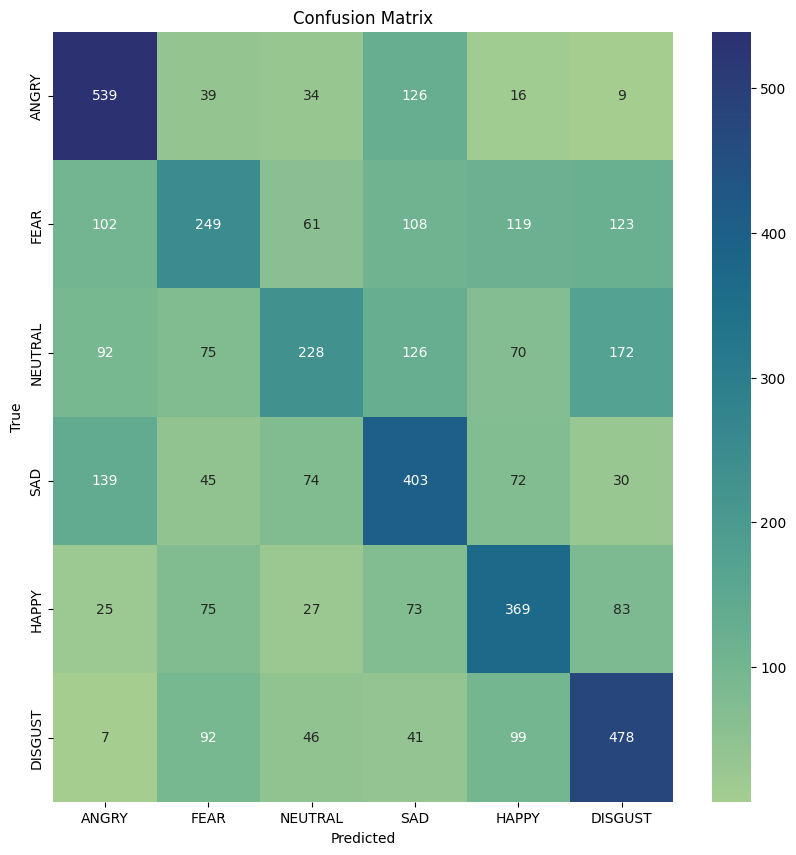

In [ ]:
cm = confusion_matrix(y_test, y_pred_decoded)
plt.figure(figsize=(10,10))
labels=['ANGRY','FEAR','NEUTRAL','SAD','HAPPY','DISGUST']
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

preci=TP/(TP+FP)
recall=TP/(TP+FN)

F_score= 2*preci*recall/(preci+recall)


In [ ]:
print('F-score: '+str(F_score.sum()/F_score.size *100)+'%')

F-score: 49.755210699943206%
